In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime

# Interest Rates
RBA monthly lending rates from 1959

In [48]:
# FILEPATH: /workspaces/investment-analytics/notebooks/finance/Interest-Rates.ipynb
# RBA monthly lending rates from 1959
csv_file = 'https://www.rba.gov.au/statistics/tables/csv/f5-data.csv'
local_file = '../data/f5-data.csv'
max_age = datetime.timedelta(days=1)
if not os.path.exists(local_file) or datetime.datetime.now() - datetime.datetime.fromtimestamp(os.path.getmtime(local_file)) > max_age:
    import urllib.request
    urllib.request.urlretrieve(csv_file, local_file)

In [49]:
# First 10 rows are descriptive header rows and data is not UTF-8 encoded, use Windows code page 1252 instead
# FILRHLBVS = Financial Interest; Lending rates; Housing loans; Banks; Variable; Standard; Owner-occupier
dfInterest = pd.read_csv(local_file, skiprows=10, encoding='cp1252', usecols=['Series ID', 'FILRHLBVS'])
dfInterest.dropna(subset=['Series ID'], inplace=True)
dfInterest.tail()

,Series ID,FILRHLBVS
774,Jul-2023,8.52
775,Aug-2023,8.52
776,Sep-2023,8.52
777,Oct-2023,8.52
778,Nov-2023,8.77


In [50]:
dfInterest.rename(columns={'Series ID': 'Date'}, inplace=True)
# source data is in the format 'Jan-1959' %b-%Y
dfInterest['Date'] = pd.to_datetime(dfInterest['Date'], format='%b-%Y')
dfInterest.tail()

,Date,FILRHLBVS
774,2023-07-01,8.52
775,2023-08-01,8.52
776,2023-09-01,8.52
777,2023-10-01,8.52
778,2023-11-01,8.77


# Inflation Rates
RBA Quarterly inflation rates from 1922

In [51]:
# RBA quarterly inflation rates from 1922
csv_file = 'https://www.rba.gov.au/statistics/tables/csv/g1-data.csv'
local_file = '../data/g1-data.csv'
max_age = datetime.timedelta(days=1)
if not os.path.exists(local_file) or datetime.datetime.now() - datetime.datetime.fromtimestamp(os.path.getmtime(local_file)) > max_age:
    import urllib.request
    urllib.request.urlretrieve(csv_file, local_file)

In [52]:
# First 10 rows are descriptive header rows and data is not UTF-8 encoded, use Windows code page 1252 instead
# GCPIAGYP = Consumer Price Index: All Groups, Percentage change from corresponding quarter of previous year
dfInflation = pd.read_csv(local_file, skiprows=10, encoding='cp1252', usecols=['Series ID', 'GCPIAGYP'])
dfInflation.dropna(subset=['Series ID'], inplace=True)
dfInflation.tail()

,Series ID,GCPIAGYP
404,Jun-2023,6.0
405,Sep-2023,5.4
406,Dec-2023,NaN
407,Mar-2024,NaN
408,Jun-2024,NaN


In [53]:
dfInflation.rename(columns={'Series ID': 'Date'}, inplace=True)
# source data is in the format 'Jan-1959' %b-%Y
dfInflation['Date'] = pd.to_datetime(dfInflation['Date'], format='%b-%Y')
dfInflation.tail()

,Date,GCPIAGYP
404,2023-06-01,6.0
405,2023-09-01,5.4
406,2023-12-01,NaN
407,2024-03-01,NaN
408,2024-06-01,NaN


# Combine Data

In [54]:
start_date = pd.to_datetime('1960-01-01')
end_date = pd.to_datetime('2025-01-01') # used to force chart to plot to end of 5 year period
dfInterest = dfInterest.loc[dfInterest['Date'] >= start_date]
dfInflation = dfInflation.loc[dfInflation['Date'] >= start_date]

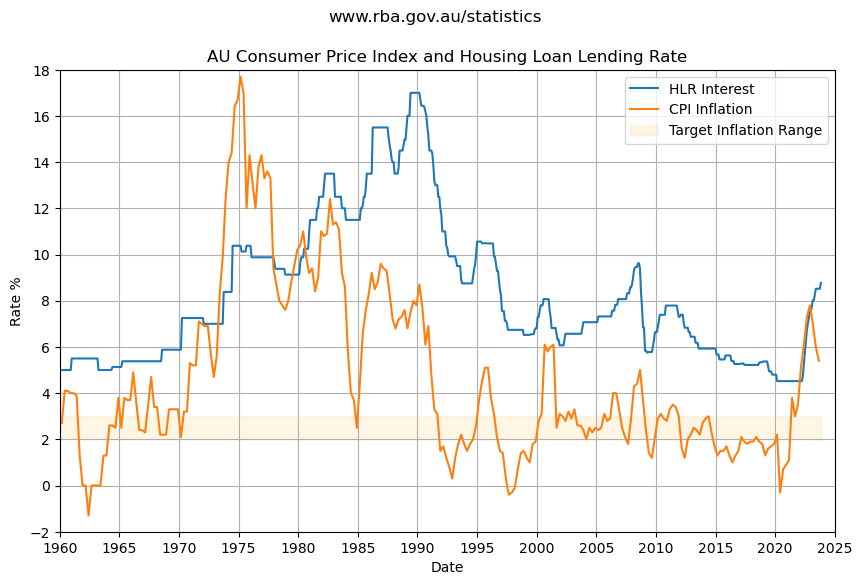

In [73]:
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 6))
plt.plot(dfInterest['Date'], dfInterest['FILRHLBVS'], label='HLR Interest')
plt.plot(dfInflation['Date'], dfInflation['GCPIAGYP'], label='CPI Inflation')
plt.xlabel('Date')
plt.ylabel('Rate %')
plt.suptitle('www.rba.gov.au/statistics')
plt.title('AU Consumer Price Index and Housing Loan Lending Rate')
plt.grid(True)
plt.xlim(left=start_date, right=end_date)
plt.ylim(bottom=-2, top=18) 
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set major ticks every 5 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years
ax.yaxis.set_major_locator(ticker.MultipleLocator(2)) 

# Add a horizontal band between y=2 and y=3
plt.fill_between(dfInterest['Date'], 2, 3, color='orange', alpha=0.1)
# Create a Patch for the legend
target_range = mpatches.Patch(color='orange', alpha=0.1, label='Target Inflation Range')
# Get the existing legend entries
handles, labels = ax.get_legend_handles_labels()
# Add the patch to the existing handles
handles.append(target_range)
# Create the legend with the existing entries and the new patch
plt.legend(handles=handles, loc='best')
plt.show()